In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
import itertools

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### data preparation

In [2]:
data=pd.read_json('C:/Users/ASUS/Python/tops_fashion.json')

In [3]:
print(data.shape[0],data.shape[1])

183138 19


In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

##### only six feature will be used 
- asin
- brand
- color
- product_type_name
- medium_image_url
- title
- formatted_price


In [5]:
data=data[['asin','brand','color','medium_image_url','product_type_name','title','formatted_price']]

In [6]:
print(data.shape[0],data.shape[1])

183138 7


In [7]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### missing data for various features
- process is called exploratory data analysis (int this we explore every feature)
- by doing this we can figure out which part can be cleaned or removed

###### basic stats for the feature: product_type_name

In [8]:
#we have total 72 unique type of producr_type_name
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [9]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [10]:
# top 10 most frequent product_type_name
product_type_count=Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

###### basic stats for feature: brand

In [11]:
print(data['brand'].describe())
#183138 - 182987 = 151 missing values

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [12]:
brand_count=Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

###### basic stats for feature: color

In [13]:
print(data['color'].describe())
# 7.2% of product are black in color
# 64956 of 183138 product have color information. That's approx 35.4%

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [14]:
color_count=Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

###### basic stats for the feature: formatted_price

In [15]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [16]:
price_count=Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

###### basic stats for feature: title

In [17]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [18]:
title_count=Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [19]:
data.to_pickle('pickels/180k_apparel_data')

In [20]:
# consider product which have pice information
# data['formatted_price'].isnull() => gives the information
# about the dataframe row's which have null values price == none/null
data=data.loc[~data['formatted_price'].isnull()]
print('Numbers of data point after eliminating price==NULL : ',data.shape[0])


Numbers of data point after eliminating price==NULL :  28395


In [21]:
# consider product which have color
# data['color'].isnull => gie the information about the dataframe row's which have null values
data=data.loc[~data['color'].isnull()]
print('Numbers of data point after eliminating color==NULL : ',data.shape[0])

Numbers of data point after eliminating color==NULL :  28385


In [22]:
data.to_pickle('pickels/28k_apparel_data')

### remove near duplicate items

##### understand about duplicates

- near duplicate ex: means same product but different sizes or same title but differnt color


In [23]:
data=pd.read_pickle('pickels/28k_apparel_data')

In [24]:
print(sum(data.duplicated('title')))

2325


#### remove duplicate: part1

In [25]:
data=pd.read_pickle('pickels/28k_apparel_data')

In [26]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [27]:
# removing all produnts with very few words in title
data_sorted=data[data['title'].apply(lambda x:len(x.split())>4)]
print('after removal of product with short description : ',data_sorted.shape[0])

after removal of product with short description :  27949


In [28]:
# sort the whole data based on title
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [29]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [30]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [31]:
data=data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [32]:
print('number of data point : ',data.shape[0])

number of data point :  17593


In [33]:
data.to_pickle('pickels/17k_apparel_data')

#### remove duplicate: part2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [2]:
data=pd.read_pickle('pickels/17k_apparel_data')

In [3]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [4]:
data=data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [5]:
print('number of data points after stge two of dedupe: ',data.shape[0])

number of data points after stge two of dedupe:  16435


In [7]:
data.to_pickle('pickels/16k_apparel_data')

### text pre-processing

In [2]:
data=pd.read_pickle('pickels/16k_apparel_data')

# NLTK download stop words. [RUN ONLY ONCE]
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

In [4]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'as', 'ourselves', 'yours', 'he', 'both', "you've", 'should', "wouldn't", 'you', 'off', 'only', "isn't", 'himself', 'because', 'its', 'itself', 'ain', 'such', 'wouldn', 'if', 'just', 'had', 'it', "that'll", 'above', 'about', 'before', 'having', 'do', 'until', 'each', 'ma', 'are', 'd', 'for', 'to', 'then', "doesn't", 'isn', 'shan', 'an', 'herself', 'which', 'your', 'in', 'a', 's', 'own', 'him', "mightn't", 'am', "mustn't", 'other', "don't", 'wasn', 'have', "didn't", 'any', 'myself', 'and', 'didn', 'did', 'than', 'weren', 'who', 'couldn', 'through', 'down', 'hers', 'few', 'against', 'can', 'no', 'our', 'all', "wasn't", 'being', 'out', "shan't", "hasn't", 've', 'now', 'here', 'the', 'does', 'm', 'me', 'ours', "you'd", 'up', 'there', 'been', 'why', 'with', 'where', "won't", 'very', 'most', 'but', 'haven', "should've", 'these', 'during', 'she', 'too', 't', 'be', 'between', "she's", 'under', 'aren', 'those', 'same', 'll', 'how', 'themselves', "weren't", 'them', 'theirs',

In [5]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

4.3252727 seconds


In [6]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [7]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

### stemming

In [8]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


### text based product similiarities

In [9]:
data=pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [10]:
# Utility Functions which we will use through the rest of the project


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

### bag of words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc



(16435, 12684)

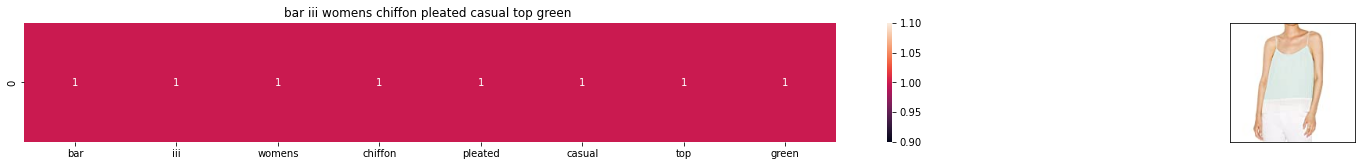

ASIN : B01CDLVBX8
Brand: Bar III
Title: bar iii womens chiffon pleated casual top green 
Euclidean similarity with the query image : 0.0


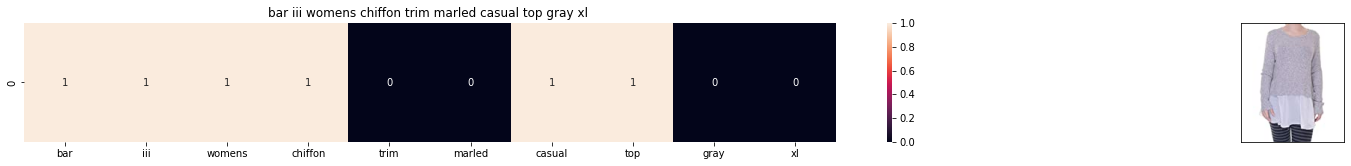

ASIN : B01BZABFIE
Brand: Bar III
Title: bar iii womens chiffon trim marled casual top gray xl 
Euclidean similarity with the query image : 2.449489742783178


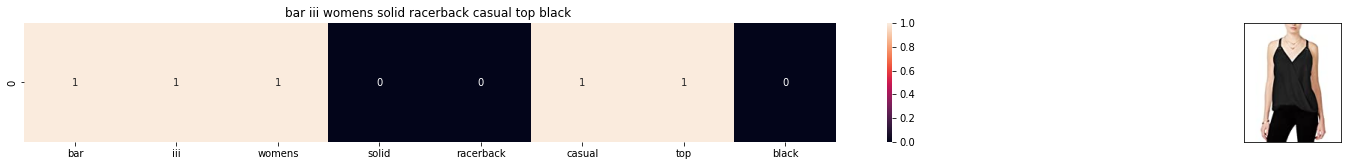

ASIN : B0724ZCX9F
Brand: Bar III
Title: bar iii womens solid racerback casual top black 
Euclidean similarity with the query image : 2.449489742783178


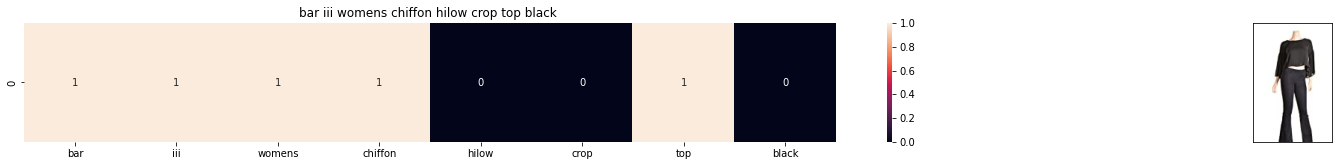

ASIN : B01BT9869M
Brand: Bar III
Title: bar iii womens chiffon hilow crop top black 
Euclidean similarity with the query image : 2.449489742783178


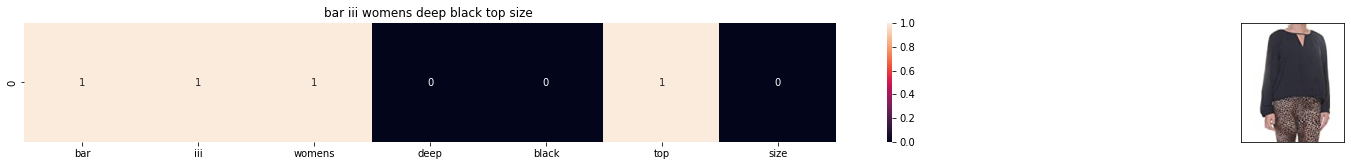

ASIN : B01N6RN4HS
Brand: Bar III
Title: bar iii womens deep black top size 
Euclidean similarity with the query image : 2.6457513110645907


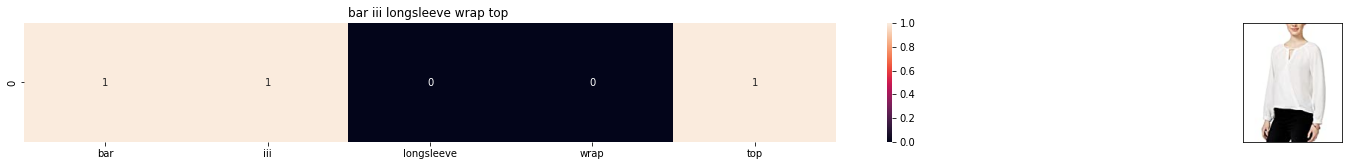

ASIN : B072LNV4RM
Brand: Bar III
Title: bar iii longsleeve wrap top 
Euclidean similarity with the query image : 2.6457513110645907


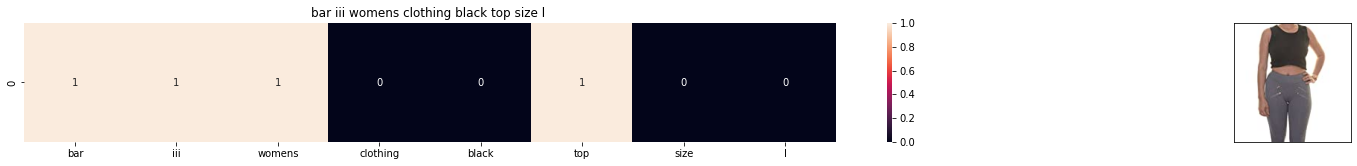

ASIN : B01KVR2YZA
Brand: Bar lll
Title: bar iii womens clothing black top size l 
Euclidean similarity with the query image : 2.6457513110645907


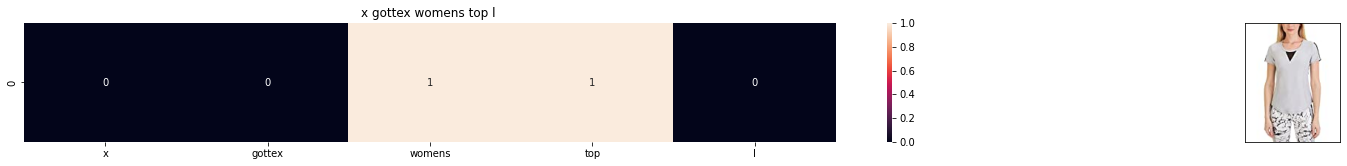

ASIN : B073M78XLP
Brand: X by Gottex
Title: x gottex womens top l 
Euclidean similarity with the query image : 2.6457513110645907


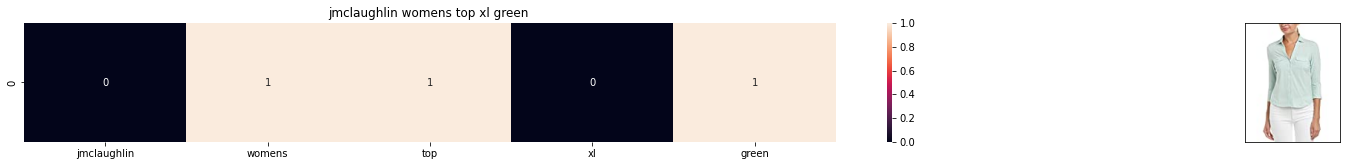

ASIN : B074KPDKMY
Brand: J. McLaughlin
Title: jmclaughlin womens top xl green 
Euclidean similarity with the query image : 2.6457513110645907


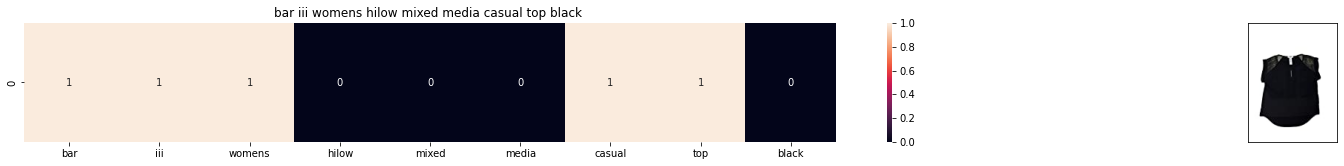

ASIN : B01LYRBHMI
Brand: Bar III
Title: bar iii womens hilow mixed media casual top black 
Euclidean similarity with the query image : 2.6457513110645907


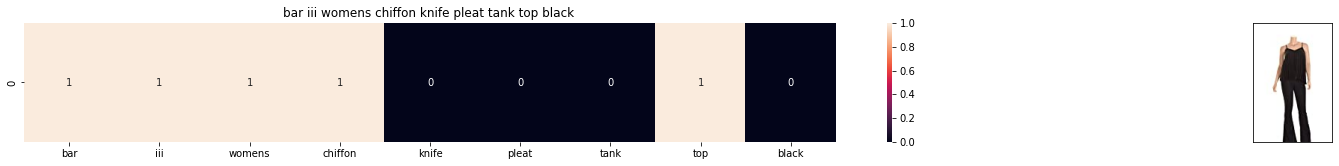

ASIN : B01GUK8EYM
Brand: Bar III
Title: bar iii womens chiffon knife pleat tank top black 
Euclidean similarity with the query image : 2.6457513110645907


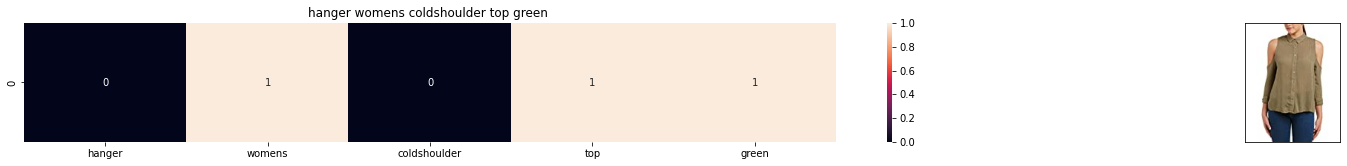

ASIN : B074F52Y28
Brand: The Hanger
Title: hanger womens coldshoulder top green 
Euclidean similarity with the query image : 2.6457513110645907


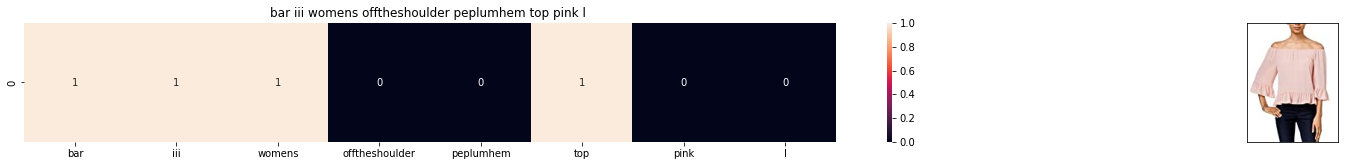

ASIN : B073HWTC1L
Brand: Bar III
Title: bar iii womens offtheshoulder peplumhem top pink l 
Euclidean similarity with the query image : 2.6457513110645907


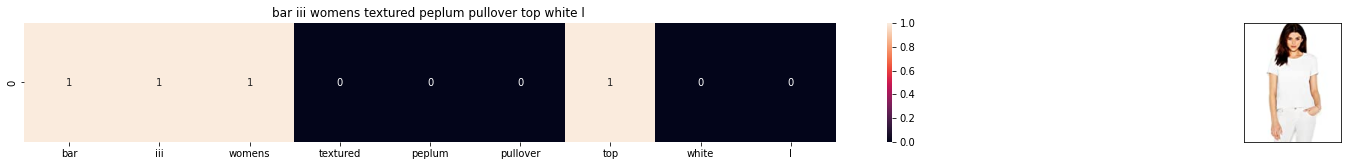

ASIN : B01EZ5PNOI
Brand: Bar III
Title: bar iii womens textured peplum pullover top white l 
Euclidean similarity with the query image : 2.8284271247461903


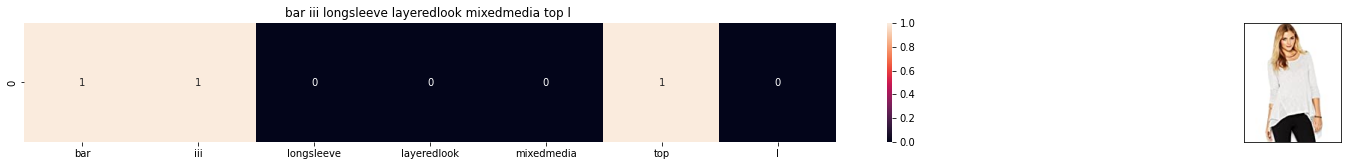

ASIN : B071SG3RT6
Brand: Bar III
Title: bar iii longsleeve layeredlook mixedmedia top l 
Euclidean similarity with the query image : 2.8284271247461903


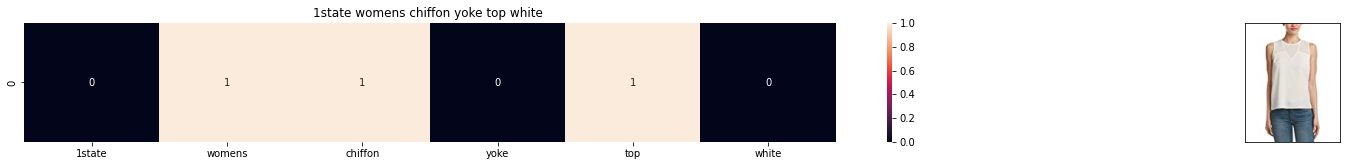

ASIN : B071YPB9P9
Brand: 1.State
Title: 1state womens chiffon yoke top white 
Euclidean similarity with the query image : 2.8284271247461903


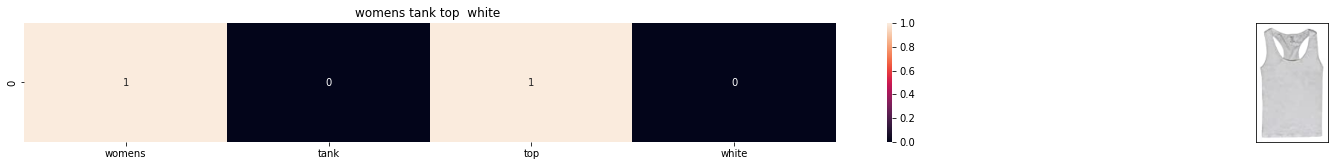

ASIN : B00JPOZ9GM
Brand: Sofra
Title: womens tank top  white 
Euclidean similarity with the query image : 2.8284271247461903


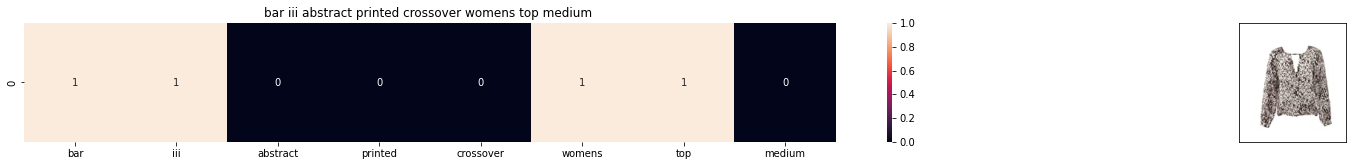

ASIN : B071JWBTBH
Brand: Bar III
Title: bar iii abstract printed crossover womens top medium 
Euclidean similarity with the query image : 2.8284271247461903


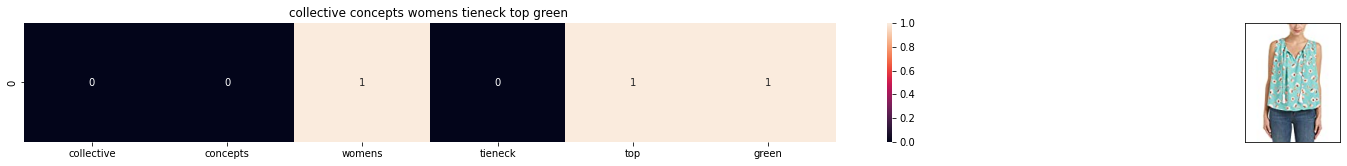

ASIN : B06Y15Y3Z7
Brand: Collective Concepts
Title: collective concepts womens tieneck top green 
Euclidean similarity with the query image : 2.8284271247461903


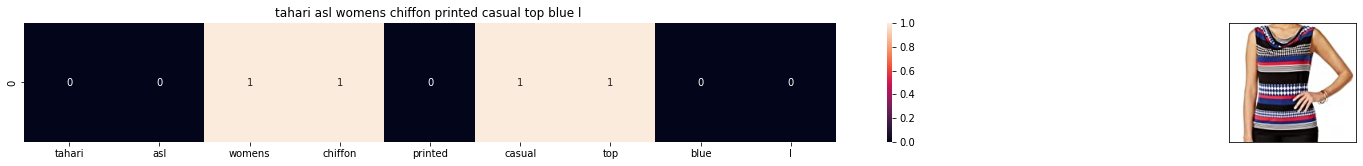

ASIN : B01M68JIFB
Brand: Tahari ASL
Title: tahari asl womens chiffon printed casual top blue l 
Euclidean similarity with the query image : 2.8284271247461903


In [16]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
        

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(931, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

### tf-idf 

In [13]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

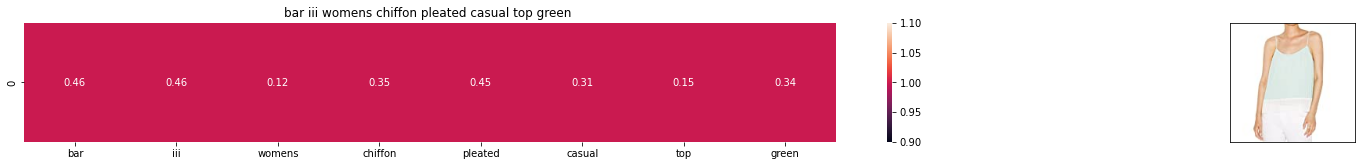

ASIN : B01CDLVBX8
BRAND : Bar III
Eucliden distance from the given image : 0.0


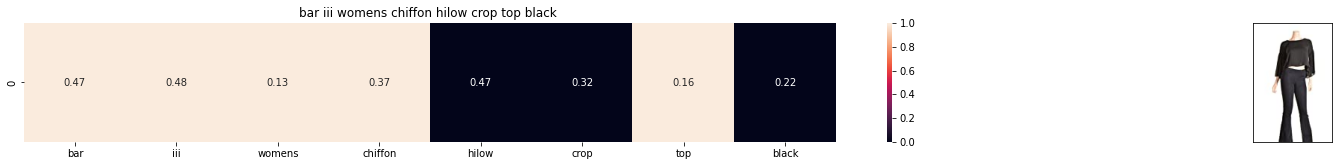

ASIN : B01BT9869M
BRAND : Bar III
Eucliden distance from the given image : 0.8851790667387737


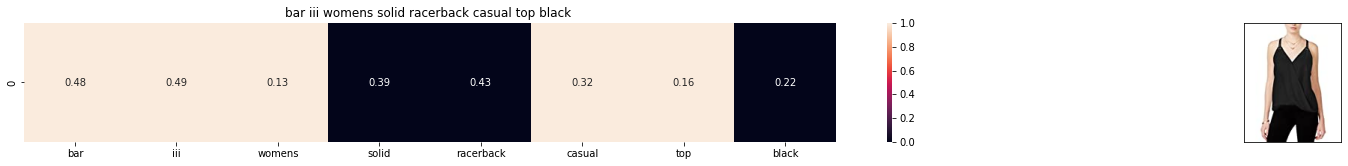

ASIN : B0724ZCX9F
BRAND : Bar III
Eucliden distance from the given image : 0.9093599127727673


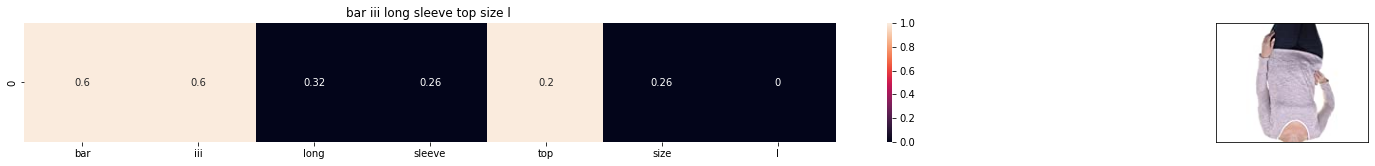

ASIN : B014V60CQ0
BRAND : Bar III
Eucliden distance from the given image : 0.9149108494974221


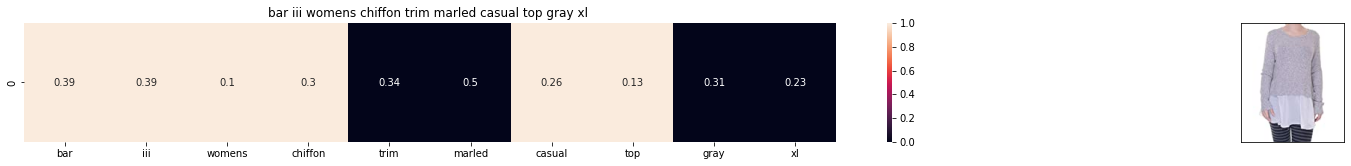

ASIN : B01BZABFIE
BRAND : Bar III
Eucliden distance from the given image : 0.9233858380403844


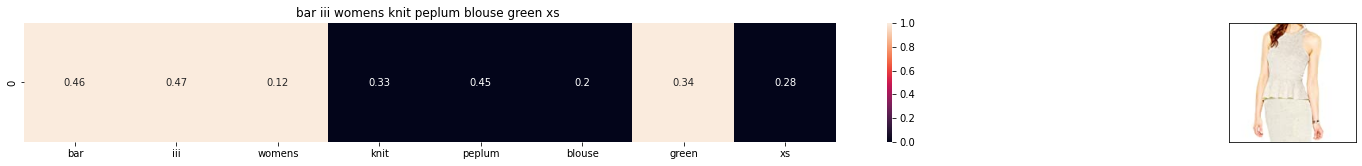

ASIN : B01AND54VS
BRAND : Bar III
Eucliden distance from the given image : 0.9368579831412406


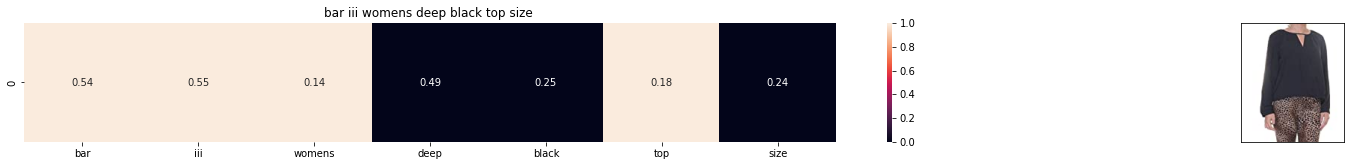

ASIN : B01N6RN4HS
BRAND : Bar III
Eucliden distance from the given image : 0.9553130127756088


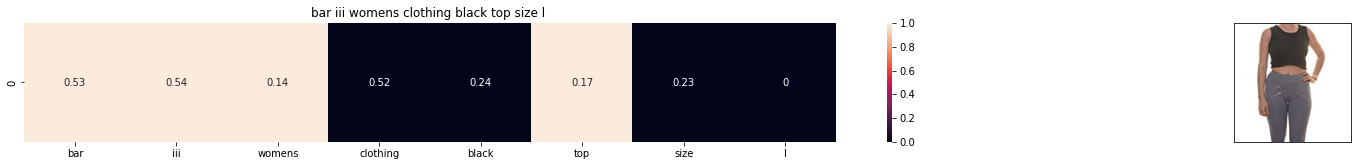

ASIN : B01KVR2YZA
BRAND : Bar lll
Eucliden distance from the given image : 0.9645461014433538


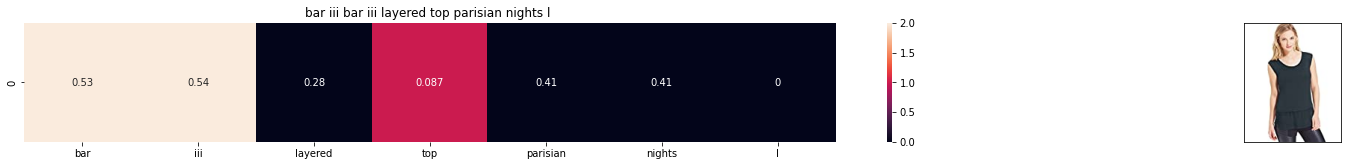

ASIN : B01KG6D1U8
BRAND : Bar lll
Eucliden distance from the given image : 0.9933235976278795


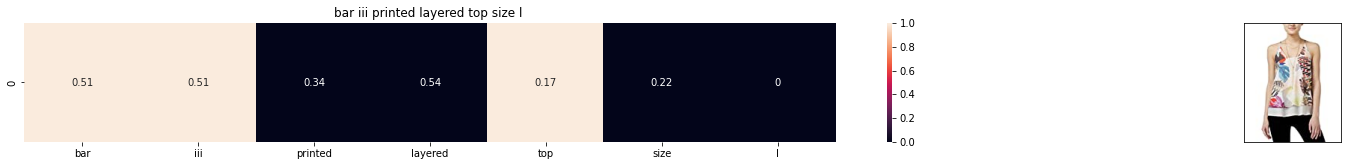

ASIN : B06XPYWQ5Y
BRAND : Bar III
Eucliden distance from the given image : 1.006127086981935


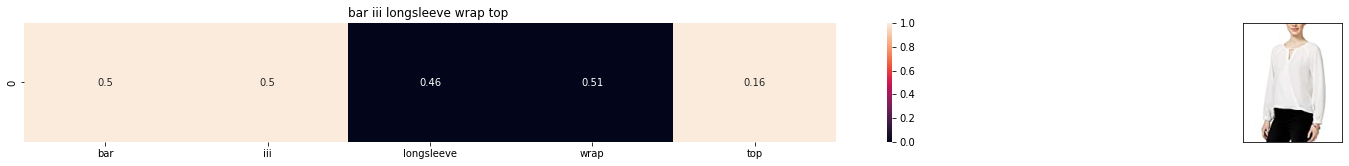

ASIN : B072LNV4RM
BRAND : Bar III
Eucliden distance from the given image : 1.0131004922576294


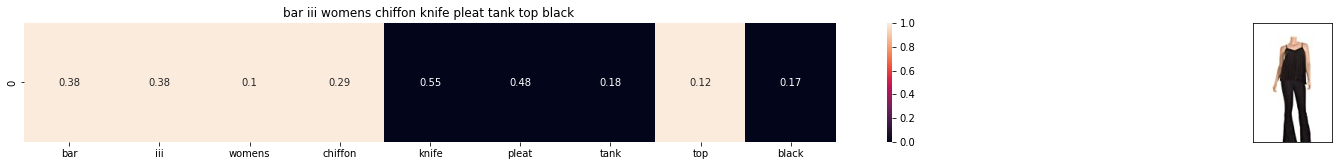

ASIN : B01GUK8EYM
BRAND : Bar III
Eucliden distance from the given image : 1.013338952568127


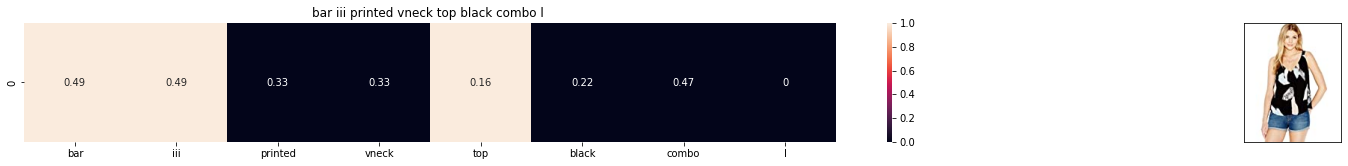

ASIN : B01KI9PNCM
BRAND : Bar lll
Eucliden distance from the given image : 1.0231987320695486


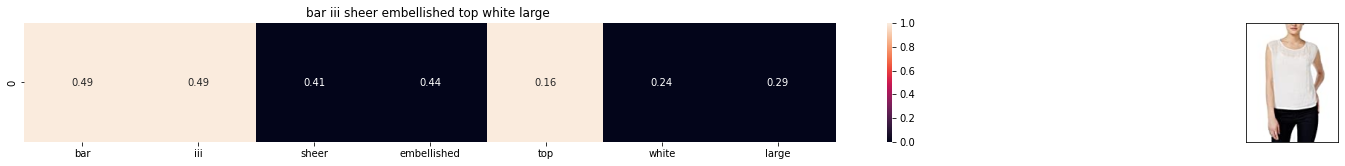

ASIN : B0727KTGH4
BRAND : Bar III
Eucliden distance from the given image : 1.0259746108766814


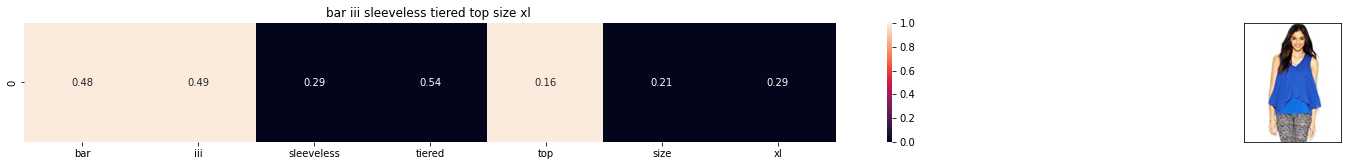

ASIN : B06XJTTHR8
BRAND : Bar III
Eucliden distance from the given image : 1.0296406995891412


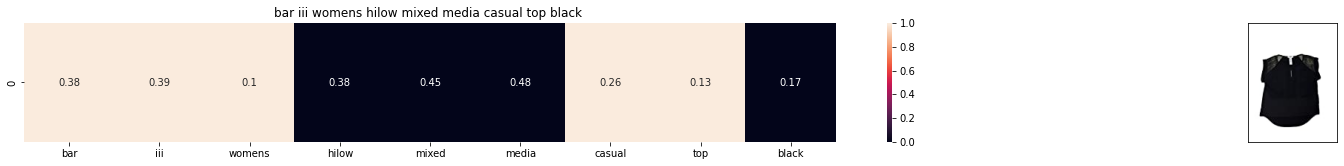

ASIN : B01LYRBHMI
BRAND : Bar III
Eucliden distance from the given image : 1.0334096925248497


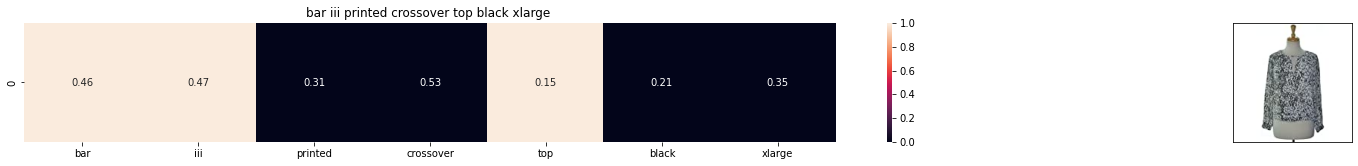

ASIN : B0751TJM3P
BRAND : Bar III
Eucliden distance from the given image : 1.0497941718020027


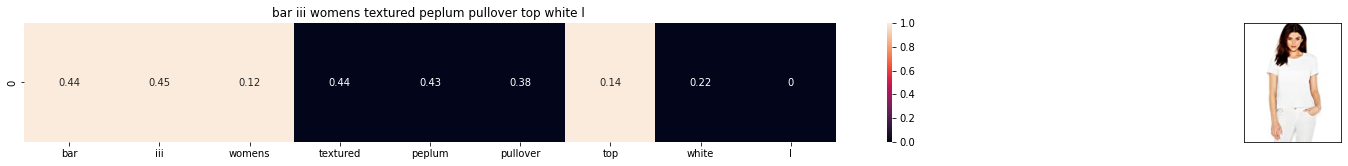

ASIN : B01EZ5PNOI
BRAND : Bar III
Eucliden distance from the given image : 1.054220995116028


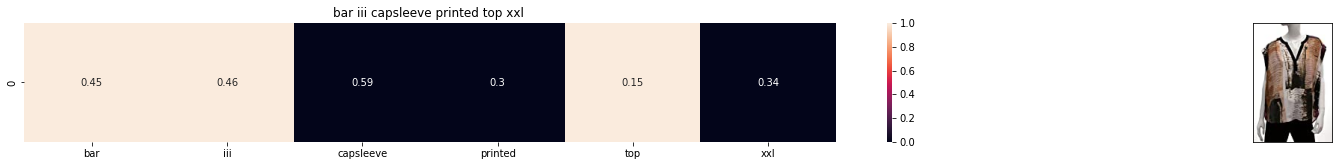

ASIN : B0716Z7N13
BRAND : Bar III
Eucliden distance from the given image : 1.0558556102475896


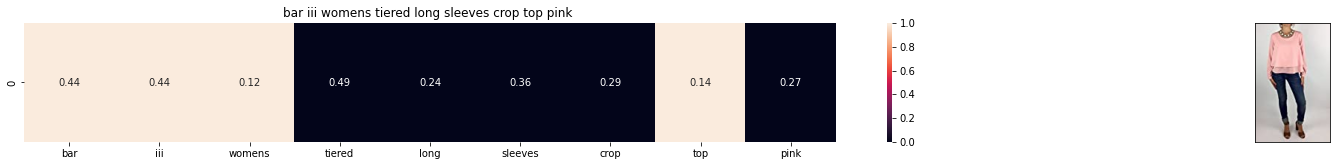

ASIN : B01DQ3AYHQ
BRAND : Bar III
Eucliden distance from the given image : 1.0576030688367164


In [19]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(931, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title